In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import datajoint as dj
from datetime import date
from matplotlib import pyplot as plt
from scipy import signal
from datetime import date,datetime,timedelta
import h5py
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Establish connection to the datajoint
dj.config['database.host'] = '34.82.94.188'
dj.config['database.user'] = 'yonib'
dj.config['database.password'] = 'yonib'
dj.conn()

schema  = dj.schema('yonib_behavior_test',locals())

# And map to the allen data
data_directory = 'C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData'
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)


Connecting yonib@34.82.94.188:3306


In [ ]:
def convert_to_array(value):
    if isinstance(value,str):
        value = np.fromstring(value[1:-1],sep = ',')
    if isinstance(value,np.ndarray) and len(value)==1:
        value = value[0]
    return value

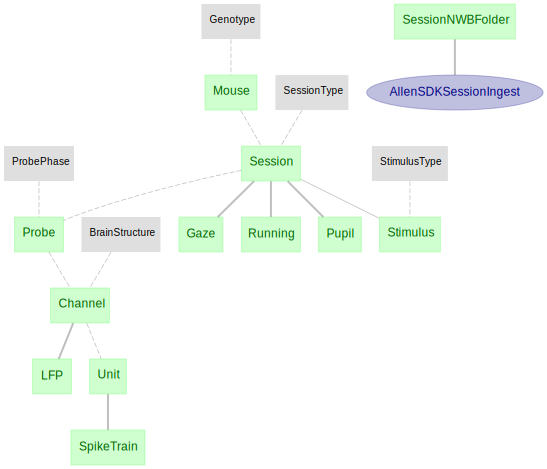

In [ ]:
@schema 
class Genotype(dj.Lookup):
    definition = """
    genotype:varchar(255)
    """
    contents = zip(['Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt'])

@schema
class SessionType(dj.Lookup):
    definition = """
    session_type:varchar(255)
    """
    contents = zip(['brain_observatory_1.1', 
                    'functional_connectivity'])


@schema
class Mouse(dj.Manual):
    definition = """
    # mouse information
    specimen_id: bigint  # unique mouse ID
    ---
    sex:enum('M','F','U') # Sex: Male, Female, Unkown
    -> Genotype
    dob:date
    """

# In my present formulation, things like channel and probe counts 
# and area ID can be found with queries but aren't included in the 
# Sessions table.
@schema
class Session(dj.Manual):
    definition = """
    session_id:bigint
    ---
    ->Mouse
    session_datetime:datetime
    ->SessionType
    publication_datetime:datetime
    """
@schema
class StimulusType(dj.Lookup):
    definition = """
    stimulus_name:varchar(255)
    """
    contents = zip(['drifting_gratings', 'flashes', 'gabors', 'invalid_presentation',
       'natural_movie_one', 'natural_movie_three', 'natural_scenes',
       'spontaneous', 'static_gratings']) 

@schema 
class Stimulus(dj.Manual):
    definition = """
    ->Session
    stimulus_presentation_id:int
    ---
    color=null:tinyblob
    contrast=null:float
    frame = null:int
    orientation = null:float
    phase = null:tinyblob
    size = null:tinyblob
    spatial_frequency = null:tinyblob
    start_time = null:float
    stimulus_block = null:int
    ->StimulusType
    stop_time = null:float
    temporal_frequency = null:tinyblob
    x_position = null:float
    y_position = null:float
    duration = null:float
    stimulus_condition_id = null:int
    """
@schema
class ProbePhase(dj.Lookup):
    definition = """
    probe_phase:varchar(255)
    """
    contents = zip(['3a', 'PXI'])
    
@schema 
class Probe(dj.Manual):
    definition = """
    probe_id:bigint
    ---
    ->Session
    ->ProbePhase
    probe_name:varchar(10)
    air_channel_index:int
    surface_channel_index:int
    sampling_rate:float
    lfp_sampling_rate:float

    """
@schema
class BrainStructure(dj.Lookup):
    definition = """
    brain_structure:varchar(10)
    """
    contents = zip(['APN', 'BMAa', 'CA1', 'CA2', 'CA3', 'COAa', 'COApm', 'CP', 'DG',
       'Eth', 'HPF', 'IGL', 'IntG', 'LD', 'LGd', 'LGv', 'LP', 'LT', 'MB',
       'MGd', 'MGm', 'MGv', 'MRN', 'NOT', 'OLF', 'OP', 'PF', 'PIL', 'PO',
       'POL', 'POST', 'PP', 'PPT', 'PRE', 'PoT', 'ProS', 'RPF', 'RT',
       'SCig', 'SCiw', 'SCop', 'SCsg', 'SCzo', 'SGN', 'SUB', 'TH', 'VIS',
       'VISal', 'VISam', 'VISl', 'VISli', 'VISmma', 'VISmmp', 'VISp',
       'VISpm', 'VISrl', 'VL', 'VPL', 'VPM', 'ZI', 'grey', 'nan'])
    
@schema
class Channel(dj.Manual):
    definition = """
    channel_id:bigint
    ---
    ->Probe
    ->BrainStructure
    structure_id = null:float
    local_channel_index:int
    probe_horizontal_position:int
    probe_vertical_position:int
    anterior_posterior_ccf_coordinate = null:float
    dorsal_ventral_ccf_coordinate = null:float
    left_right_ccf_coordinate=null:float
    """ 
@schema
class LFP(dj.Manual):
    definition = """
    ->Channel
    ---
    lfp_ts:longblob
    lfp:longblob
    """
    
@schema 
class Unit(dj.Manual):
    definition = """
    unit_id:bigint
    ---
    ->Channel
    pt_ratio = null:float
    amplitude = null:float
    amplitude_cutoff = null:float
    cumulative_drift = null:float
    d_prime = null:float
    duration = null:float
    firing_rate = null:float
    halfwidth = null:float
    isi_violations = null:float
    isolation_distance = null:float
    l_ratio = null:float
    max_drift = null:float
    nn_hit_rate = null:float
    nn_miss_rate = null:float
    presence_ratio = null:float
    recovery_slope = null:float
    repolarization_slope = null:float
    silhouette_score = null:float
    snr = null:float
    spread = null:float
    velocity_above = null:float
    velocity_below = null:float
    """
    
@schema
class SpikeTrain(dj.Manual):
    definition = """
    ->Unit
    ---
    spike_ts:longblob
    """
    

@schema
class Running(dj.Manual):
    definition= """
    ->Session
    ---
    running_ts=null:longblob
    velocity=null:longblob
    """

@schema
class Pupil(dj.Manual):
    definition= """
    ->Session
    ---
    pupil_ts:longblob
    pupil_size:longblob
    """
    
@schema
class Gaze(dj.Manual):
    definition= """
    ->Session
    ---
    gaze_ts:longblob
    gaze_position:longblob
    """

@schema
class SessionNWBFolder(dj.Manual):
    definition = """
    nwb_folder:varchar(256)
    """

# Get the session table
sessions = pd.read_csv('C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\sessions.csv',index_col = 'id')
probes = pd.read_csv('C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\probes.csv',index_col = 'id')
channels = pd.read_csv('C:\\Users\\yoni.browning\\Documents\\DataJoint\\AllenData\\channels.csv',index_col = 'id')

@schema
class AllenSDKSessionIngest(dj.Imported):
    definition = """
    ->SessionNWBFolder
    """
    def make(self,key):
        # Add the data to this table
        session_id = int(os.path.split(key['nwb_folder'])[-1].split('_')[-1])
        print(session_id)
        session = cache.get_session_data(session_id)        
        ### Add Session data 
        row = sessions[sessions.index == session.ecephys_session_id].to_dict(orient = 'records')[0]
        session_datetime = datetime.strptime(row['date_of_acquisition'], "%Y-%m-%dT%H:%M:%S%z")
        publication_datetime = datetime.strptime(row['published_at'], "%Y-%m-%dT%H:%M:%S%z")
        session_id = session.ecephys_session_id
        
        # insert the mouse data
        mouse_data = {'specimen_id':row['specimen_id'],
                         'sex':row['sex'],
                         'genotype':row['genotype'],
                         'dob':session_datetime.date()-timedelta(row['age_in_days'])}
        Mouse().insert1(mouse_data,skip_duplicates = True)
        
        # insert the session data
        session_data = {'session_id':session_id,
                            'specimen_id':row['specimen_id'],
                            'session_datetime':session_datetime,
                            'publication_datetime':publication_datetime,
                            'session_type':row['session_type'],
            }
        Session().insert1(session_data,skip_duplicates = True)
        print('Added Session')

        ### Add Probe data
        # All of this info is probably in the session struct somewhere, but I am too lazy to find it.
        probe_df = probes[probes['ecephys_session_id']==session_id].copy() #Copy is just to stop errors from being spit out.
        probe_df.reset_index(inplace = True)
        probe_df.rename(columns ={'id':'probe_id',
                                 'name':'probe_name',
                                 'phase':'probe_phase',
                                 'ecephys_session_id':'session_id'},inplace =True)
        probe_df_dict = probe_df[['probe_id',
                                  'session_id',
                                  'probe_name',
                                  'probe_phase',
                                  'air_channel_index',
                                  'surface_channel_index',
                                  'sampling_rate',
                                  'lfp_sampling_rate']].to_dict(orient = 'records')
        Probe().insert(probe_df_dict,skip_duplicates = True)
        print('Added Probe')

        ### Add Channel data
        # All of this info is probably in the session struct somewhere, but I am too lazy to find it.
        channels_df = channels[np.isin(channels['ecephys_probe_id'],probe_df['probe_id'])].copy()        
        channels_df.reset_index(inplace = True)
        channels_df.rename(columns ={'id':'channel_id',
                                 'ecephys_probe_id':'probe_id',
                                 'ecephys_structure_id':'structure_id',
                                 'ecephys_structure_acronym':'brain_structure',
                                 'local_index':'local_channel_index'},inplace =True)
        
        channels_df['brain_structure'] = channels_df['brain_structure'].astype(str)
        channels_df['structure_id'] = channels_df['structure_id'].astype(float)
        channels_df['anterior_posterior_ccf_coordinate'] = channels_df['anterior_posterior_ccf_coordinate'].astype(float)
        channels_df['dorsal_ventral_ccf_coordinate'] = channels_df['dorsal_ventral_ccf_coordinate'].astype(float)
        channels_df['left_right_ccf_coordinate'] = channels_df['left_right_ccf_coordinate'].astype(float)
        channels_df_dict = channels_df.to_dict(orient = 'records')
        Channel().insert(channels_df_dict,skip_duplicates = True)
        print('Added Channel')

        ### Add Unit data
        units_df = session.units
        units_df.reset_index(inplace = True)
        units_df.rename(columns ={'id':'unit_id',
                                 'peak_channel_id':'channel_id',
                                 'waveform_PT_ratio':'pt_ratio',
                                 'L_ratio':'l_ratio',
                                 'waveform_amplitude':'amplitude',
                                 'waveform_recovery_slope':'recovery_slope',
                                 'waveform_velocity_above':'velocity_above',
                                 'waveform_velocity_below':'velocity_below',
                                 'waveform_spread':'spread',
                                 'waveform_halfwidth':'halfwidth',
                                 'waveform_repolarization_slope':'repolarization_slope',
                                 'waveform_duration':'duration',
                                 },inplace =True)
        units_df = units_df[['unit_id',
                            'channel_id',
                            'pt_ratio',
                             'amplitude',
                            'amplitude_cutoff',
                            'cumulative_drift',
                            'd_prime',
                            'duration',
                            'firing_rate',
                            'halfwidth',
                            'isi_violations',
                            'isolation_distance',
                            'l_ratio',
                            'max_drift',
                            'nn_hit_rate',
                            'nn_miss_rate',
                            'presence_ratio',
                            'recovery_slope',
                            'repolarization_slope',
                            'silhouette_score',
                            'snr',
                            'spread',
                            'velocity_above',
                            'velocity_below']].to_dict(orient = 'records')
        Unit().insert(units_df,skip_duplicates = True)
        print('Added Unit')

        ### Add Spike times for units
        #dict_list = []
        #for ii,unit_id in enumerate(session.spike_times.keys()):
        #    SpikeTrain().insert1({'unit_id':unit_id,'spike_ts':session.spike_times[unit_id]},
        #                         skip_duplicates=True)
        # print('Added SpikeTrain')


        ### Add Stimulus Data
        Running().insert1({'session_id':session_id,
                           'running_ts':session.running_speed.start_time.values,
                           'velocity':session.running_speed.velocity.values},
                          skip_duplicates=True)
        print('Added Running')
        
        ### Add other behavior data
        # Get the stimulus presentations
        rf_stim_table = session.stimulus_presentations
        rf_stim_table.reset_index(inplace=True)
        rf_stim_table.insert(0,'session_id',(session.ecephys_session_id*np.ones(len(rf_stim_table))).astype(int))
        K = rf_stim_table.keys()
        # Fix 'null' to be None variables
        for ii in range(len(K)):
            rf_stim_table[K[ii]][rf_stim_table[K[ii]]=='null'] = None
        # Convert strings to arrays
        rf_stim_table['color'] = rf_stim_table['color'].apply(convert_to_array)
        rf_stim_table['phase'] = rf_stim_table['phase'].apply(convert_to_array)
        rf_stim_table['size'] = rf_stim_table['size'].apply(convert_to_array)
        rf_stim_table['temporal_frequency'] = rf_stim_table['temporal_frequency'].apply(convert_to_array)
        rf_stim_table['spatial_frequency'] = rf_stim_table['spatial_frequency'].apply(convert_to_array)
        # Write data to the table 
        Stimulus().insert(rf_stim_table.to_dict(orient = 'records'),skip_duplicates = True)
        print('Added Stimulus')

        """ 
        pupil_data = session.get_pupil_data()
        if pupil_data is None:
            continue
        else:
            print('Please add something to handle pupil data!!!')
            
        gaze_data = session.get_gaze_data()
        if gaze_data is None:
            continue
        else:
            print('Please add something to handle gaze data!!!')
        """
        # This goes at the end for debugging
        #self.insert1(key)

dj.ERD(schema)

In [ ]:
# Build the table. This step takes some time to run!
NWB_data = ({'nwb_folder':"C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_715093703"},
            {'nwb_folder':'C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_719161530'},
            {'nwb_folder':'C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_721123822'},
            {'nwb_folder':'C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_732592105'},
            {'nwb_folder':'C:/Users/yoni.browning/Documents/DataJoint/AllenData/session_737581020'})
SessionNWBFolder().insert(NWB_data,skip_duplicates = True)
AllenSDKSessionIngest().populate()


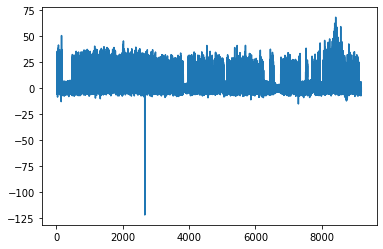

In [14]:
data = (Running()&'session_id=715093703').fetch1()
plt.plot(data['running_ts'],data['velocity'])

In [ ]:
%%timeit -n 1 -r 1
session = cache.get_session_data(737581020)
rf_stim_table = session.stimulus_presentations
rf_stim_table.reset_index(inplace=True)
rf_stim_table.insert(0,'session_id',(session.ecephys_session_id*np.ones(len(rf_stim_table))).astype(int))
K = rf_stim_table.keys()
for ii in range(len(K)):
    rf_stim_table[K[ii]][rf_stim_table[K[ii]]=='null'] = None
rf_stim_table['color'] = rf_stim_table['color'].apply(convert_to_array)
rf_stim_table['phase'] = rf_stim_table['phase'].apply(convert_to_array)
rf_stim_table['size'] = rf_stim_table['size'].apply(convert_to_array)
rf_stim_table['temporal_frequency'] = rf_stim_table['temporal_frequency'].apply(convert_to_array)
rf_stim_table['spatial_frequency'] = rf_stim_table['spatial_frequency'].apply(convert_to_array)
rf_stim_table.head()

In [ ]:

Stimulus().insert(rf_stim_table.to_dict(orient = 'records'))

In [ ]:
rf_stim_table.contrast[rf_stim_table.contrast=='null'] = None
rf_stim_table.color[rf_stim_table.color=='null'] = None
rf_stim_table.phase[rf_stim_table.phase=='null'] = None
rf_stim_table.size[rf_stim_table.size=='null'] = None
rf_stim_table.spatial_frequency[rf_stim_table.spatial_frequency=='null'] = None
rf_stim_table.spatial_frequency[rf_stim_table.temporal_frequency=='null'] = None

rf_stim_table.stimulus_block[rf_stim_table.stimulus_block=='null'] = None
rf_stim_table.x_position[rf_stim_table.x_position=='null'] = None
rf_stim_table.y_position[rf_stim_table.y_position=='null'] = None


In [ ]:
dict_array = rf_stim_table.to_dict(orient = 'records')
for ii in range(len(dict_array)):
    Stimulus().insert1(dict_array[ii],skip_duplicates=True)

In [ ]:
rf_stim_table.color[rf_stim_table.color!=rf_stim_table.color[0]]

In [ ]:
np.fromstring(rf_stim_table['phase'][2][1:-1])

In [ ]:
np.fromstring(rf_stim_table['phase'][2][1:-1],sep= {',','[',']'})

In [ ]:
Stimulus().drop()

In [ ]:
dict_array[ii]

In [ ]:
rf_stim_table['spatial_frequency'] = rf_stim_table['spatial_frequency'].apply(convert_to_array)

In [ ]:
Stimulus()

In [ ]:
stimulus_df = Stimulus().fetch(format = 'frame')

In [4]:
static_frame = (Stimulus&'session_id = 715093703'&'stimulus_name = "static_gratings"').fetch(format='frame')
spiketrain_frame = (SpikeTrain&(Unit&(Channel&(Probe&'session_id = 715093703')))).fetch(format = 'frame')

In [5]:
def raster_data(trigger_ts,spike_ts,min_ts=0,max_ts=.25):
    spktrl = [None]*len(trigger_ts)
    spkts = [None]*len(trigger_ts)
    for ii,trigger in enumerate(trigger_ts):
        this_spike_ts = spike_ts-trigger;
        this_spike_ts = np.array(this_spike_ts[np.logical_and(this_spike_ts>=min_ts,this_spike_ts<max_ts)])
        spkts[ii] = this_spike_ts
        spktrl[ii] = ii*np.ones(this_spike_ts.shape)
    return np.hstack(spkts[:]),np.hstack(spktrl)

this_spkts = spiketrain_frame['spike_ts'].values[0]

(spkts,spktrl) = raster_data(static_frame.start_time.values,this_spkts)

In [13]:
[_,inv] = np.unique(static_frame.orientation,return_inverse=True)


In [21]:
schema.list_tables()

['#genotype',
 '#session_type',
 '#probe_phase',
 '#brain_structure',
 'session_n_w_b_folder',
 '#stimulus_type',
 'mouse',
 '_allen_s_d_k_session_ingest',
 'session',
 'probe',
 'pupil',
 'gaze',
 'running',
 'stimulus',
 'channel',
 'unit',
 'l_f_p',
 'spike_train']

In [ ]:
inv[spktrl.astype(int)]

In [22]:
Probe().fetch('session_id')

array([715093703, 715093703, 715093703, 715093703, 715093703, 715093703,
       719161530, 719161530, 719161530, 719161530, 719161530, 719161530,
       721123822, 721123822, 721123822, 721123822, 721123822, 721123822,
       732592105, 732592105, 732592105, 732592105, 732592105, 737581020,
       737581020, 737581020, 737581020, 737581020, 737581020], dtype=int64)